# **Importación de Librerías**

In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [2]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

import optuna
from optuna.trial import TrialState

import time

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
%load_ext autoreload
%autoreload 2

from utils.load_data import *
from utils.train_predict import train_validate_loop, predict
from utils.early_stopping import EarlyStopping
from utils.metrics import *

from models.lstm import *

In [4]:
OPTUNA_STORAGE = "sqlite:///db.sqlite3"

In [5]:
DATA_DIR = "/users/bbas/TrabajoFinal/databases"
GROUP = "Grupo1"
SIMULATION = "Simulacion_1.dta"
FILEPATH = os.path.join(DATA_DIR, GROUP, SIMULATION)

**Terminología**:
* Tipo 1: individuos tratados.
* Tipo 2: individuos de control (i.e. podrían haber sido tratados pero por alguna razón no lo fueron)
* Tipo 3: ni tratados ni de control.

In [6]:
type1_df, type2_df, type3_df = get_dfs(FILEPATH)

print(f"Tenemos {len(type1_df)} indivuduos de tipo 1.")
print(f"Tenemos {len(type2_df)} indivuduos de tipo 2.")
print(f"Tenemos {len(type3_df)} indivuduos de tipo 3.")

Tenemos 100 indivuduos de tipo 1.
Tenemos 100 indivuduos de tipo 2.
Tenemos 800 indivuduos de tipo 3.


# **Conjunto de entrenamiento**
En el conjunto de entrenamiento, metemos:
* Todos los de tipo 1 (con target 1)
* Algunos de tipo 3 (con target 0).


In [7]:
# De los individuos de tipo 3, vamos a meter 600 en el conjunto de entrenamiento
# de forma tal de tener en total 700 (600 + 100, 70%) individuos en en este conjunto.
type3_train = 600
# A los que sobran los metemos en el de test
type3_test  = len(type3_df) - type3_train

In [8]:
X_train_df = pd.concat([type1_df, type3_df[:type3_train]], ignore_index=True)
y_train_df = X_train_df['tratado']

print(len(X_train_df), len(y_train_df))
print(X_train_df.shape, y_train_df.shape)

700 700
(700, 8) (700,)


In [9]:
y_train_df.value_counts()

tratado
0    600
1    100
Name: count, dtype: int64

Vemos que el conjunto de entrenamiento está desbalanceado: tiene 100 datos con label 1 y 600 con label 0. Vamos a dejar el dataset así y corregirlo asignando pesos a la función de pérdida durante el entrenamiento. Calculo los pesos acá:

In [10]:
# Weights inversely proportional to frequency
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_df), y=y_train_df)

print(f"Peso para la clase 0 (mayoritaria): {weights[0]}")
print(f"Peso para la clase 1 (minoritaria): {weights[1]}")

Peso para la clase 0 (mayoritaria): 0.5833333333333334
Peso para la clase 1 (minoritaria): 3.5


# **Conjunto de test**
En el conjunto de test, metemos:
* Todos los de tipo 2 (con target 1)
* Los que sobraron de tipo 3 (con target 0).

In [11]:
X_test_df = pd.concat([type2_df, type3_df[type3_train:]], ignore_index=True)
y_test_df = X_test_df['control']

print(len(X_test_df), len(y_test_df))
print(X_test_df.shape, y_test_df.shape)

300 300
(300, 8) (300,)


Estandarizamos:

In [12]:
required_periods = 4
value_columns = ['inicio_prog'] + [f'y(t-{i})' for i in range(required_periods, 0, -1)]

In [13]:
scaler =  StandardScaler().fit(X_train_df[value_columns])

X_train_df[value_columns] = scaler.transform(X_train_df[value_columns])
X_test_df [value_columns] = scaler.transform(X_test_df [value_columns])

# **LSTM**

Basados en el documento `docs/lstm.md`, transformemos los datos que tenemos a la forma que necesitan las LSTM:
`(batch_size, sequence_length, num_features)`.

Cada fila es un individuo y en cada fila ya tenemos todo lo que necesitamos, los 4 datos temporales (`y(t-4)`, `y(t-3)`, `y(t-2)`, `y(t-1)`) y además el dato estático (`inicio_prog`) que lo vamos a tener que repetir cuatro veces para tener la dimensión que deseamos.

In [14]:
time_steps = 4
num_features = 2

In [15]:
X_train_tensor = get_lstm_input(X_train_df, time_steps, num_features)
X_test_tensor  = get_lstm_input(X_test_df , time_steps, num_features)

# When using BCEWithLogitsLoss as loss function, the targets should be casted to float
y_train_tensor = torch.tensor(y_train_df, dtype=torch.float)
y_test_tensor  = torch.tensor(y_test_df , dtype=torch.float)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set  = TensorDataset(X_test_tensor , y_test_tensor)

## **Búsqueda de hiperparámetros con Optuna**

In [16]:
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# study = optuna.create_study(
#     direction="minimize",
#     storage=OPTUNA_STORAGE,
#     study_name=f"study_{timestamp}"
# )
# study.optimize(
#     lambda trial: objective(trial, train_set, test_set, weights),
#     n_trials=100,
#     timeout=600,
#     n_jobs=-1,
#     show_progress_bar=True
# )

# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

## **Studies de Optuna**

In [32]:
# Get all study summaries
study_summaries = optuna.get_all_study_summaries(storage=OPTUNA_STORAGE)

data = []
for summary in study_summaries:
    study_name = summary.study_name
    start_date = summary.datetime_start.strftime("%Y-%m-%d %H:%M:%S")
    best_trial_id = summary.best_trial.number if summary.best_trial else None
    best_value = summary.best_trial.value if summary.best_trial else None
    data.append([study_name, start_date, best_trial_id, best_value])

# Create a DataFrame
optuna_studies_df = pd.DataFrame(data, columns=["Study name", "Start date", "Best trial id", "Best objective value"])

# Display the DataFrame
optuna_studies_df

,Study name,Start date,Best trial id,Best objective value
0,study_20241126-163837,2024-11-26 16:38:37,22,0.050632


## **Eliminar un study de Optuna**

In [ ]:
to_delete = []
for study_name in to_delete:
    optuna.delete_study(study_name=study_name, storage=OPTUNA_STORAGE)

## **Entrenamiento del modelo con mejores hiperparámetros**

In [33]:
# Retrieve study
study = optuna.load_study(study_name="study_20241126-163837", storage=OPTUNA_STORAGE)

best_params = study.best_trial.params
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hidden_size = best_params['hidden_size']
n_layers = best_params['n_layers']
model = LSTMClassifier(num_features, hidden_size, 1, n_layers).to(device)

lr = best_params['lr']
optimizer_name = best_params['optimizer']
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

batch_size = best_params['batch_size']
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(weights[1], dtype=torch.float32)
)

epochs = best_params['n_epochs']
trained_model, y_train_accs, train_losses, y_test_accs, test_losses = train_validate_loop(
    model, train_loader, test_loader, optimizer, loss_fn, epochs
)

  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 1
Train loss: 0.6871 | Train accuracy: 0.7914
Test loss : 1.0929 | Test accuracy : 0.7367
----------------------------------------------------------------
Epoch 2
Train loss: 0.7394 | Train accuracy: 0.8743
Test loss : 1.1232 | Test accuracy : 0.7800
----------------------------------------------------------------
Epoch 3
Train loss: 0.7328 | Train accuracy: 0.7986
Test loss : 1.0512 | Test accuracy : 0.7333
----------------------------------------------------------------
Epoch 4
Train loss: 0.6941 | Train accuracy: 0.8443
Test loss : 1.0824 | Test accuracy : 0.7567
----------------------------------------------------------------
Epoch 5
Train loss: 0.6749 | Train accuracy: 0.8814
Test loss : 1.1659 | Test accuracy : 0.7733
----------------------------------------------------------------
Epoch 6
Train loss: 0.6839 | Train accuracy: 0.8829
Test loss : 1.2269 | Test accuracy : 0.7833
----------------------------------------------------------------
Epoch 7
Train loss: 0.6690 | Train

In [ ]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study).show()

In [39]:
trained_model.to('cpu')

y_test_pred = trained_model(X_test_tensor)
y_test_pred = predict(y_test_pred, loss_fn).squeeze()

train_features_mean = get_features_mean(X_train_tensor, y_train_tensor)
test_features_mean  = get_features_mean(X_test_tensor , y_test_pred)

print(f"Train features mean: {train_features_mean}")
print(f"Test  features mean: {test_features_mean}")
print()
print(f"Sum of differences: {sum(abs(train_features_mean - test_features_mean))}")

Train features mean: tensor([0.9415, 1.0184, 1.0015, 0.9243])
Test  features mean: tensor([0.9180, 1.0102, 0.9695, 0.9264])

Sum of differences: 0.06566202640533447


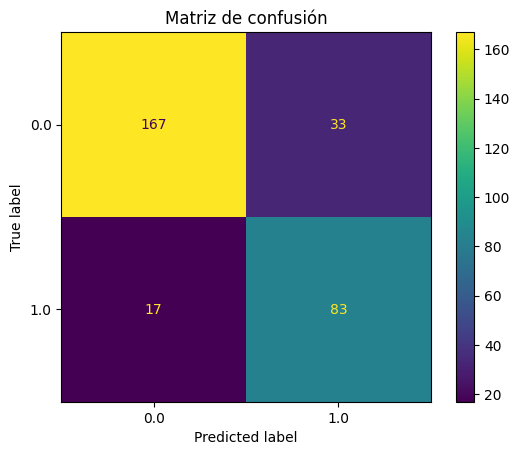

In [40]:
confusion_matrix_plot(y_test_tensor, y_test_pred)